## Gaussian Mixture Model (GMM) Algorithm

## Table of Contents
1. Implementation Overview
2. Key Components
3. Algorithm Comparison
4. Results Analysis
5. Visual Interpretation
6. Academic Insights

## 1. Implementation Overview

This implementation compares:
- **Custom GMM** (implemented from scratch using EM algorithm)
- **Scikit-learn's GMM** (optimized production implementation)


## Dataset Preparation

In [6]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score, mutual_info_score
import os

In [7]:
# Create the results directory if it doesn't exist
results_directory = "./../results"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"


In [8]:
iris_df = pd.read_csv(iris_dataset_path)
print(iris_df.head())
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)
true_labels_iris=iris_df['species']

iris_df = iris_df.drop(columns=['species'])


true_labels_ai_global_index=ai_global_index_df['Cluster']
ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", 
    "Infrastructure", 
    "Operating Environment", 
    "Research", 
    "Development", 
    "Government Strategy", 
    "Commercial", 
    "Total score"
]

income_order = {'Lower middle': 0, 'Upper middle': 1, 'High': 2}
ai_global_index_df['Income group'] = ai_global_index_df['Income group'].map(income_order)
# ai_global_index_df = pd.get_dummies(ai_global_index_df, columns=ai_global_index_categorical_cols)
true_labels_global_earthquake_data=global_earthquake_data_df['status']
print(true_labels_global_earthquake_data)
earthquake_drop_cols = [
    'id', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
    'ids', 'sources', 'types', 'place', 'placeOnly', 'location', 
    'what3words', 'locationDetails'
]
global_earthquake_data_df = global_earthquake_data_df.drop(columns=earthquake_drop_cols)
print(global_earthquake_data_df.describe())

earthquake_categorical_cols = [
    'type', 'alert', 'status', 'net', 'magType', 'geometryType',
    'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'timezone'
]
earthquake_numerical_cols = [
    "magnitude", "felt", "cdi", "mmi", "tsunami", "sig",
    "nst", "dmin", "rms", "gap", "depth", "latitude",
    "longitude", "distanceKM"
]
global_earthquake_data_df[earthquake_categorical_cols] = global_earthquake_data_df[earthquake_categorical_cols]
# global_earthquake_data_df = pd.get_dummies(global_earthquake_data_df, columns=earthquake_categorical_cols)

datasets = {
    "iris": (iris_df,true_labels_iris),
    "ai_global_index": (ai_global_index_df,true_labels_ai_global_index),
    "global_earthquake": (global_earthquake_data_df,None)
}

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
0       reviewed
1       reviewed
2       reviewed
3       reviewed
4       reviewed
          ...   
1132    reviewed
1133    reviewed
1134    reviewed
1135    reviewed
1136    reviewed
Name: status, Length: 1137, dtype: object
         magnitude           felt          cdi          mmi      tsunami  \
count  1137.000000    1137.000000  1137.000000  1137.000000  1137.000000   
mean      4.856675     414.408091     2.925242     4.320141     0.059807   
std       1.047840    5746.971362     2.562707     1.453949     0.237232   
min       3.000000       0.000000     0.000000     1.000000     0.000000   
25%    

## Custom GMM Implementation

In [9]:
# Custom Gaussian Mixture Model (GMM) Implementation
class CustomGMM:
    def __init__(self, num_components=3, max_iterations=100, tolerance=1e-4, reg_covar=1e-6,random_state=None):
        """
        Initialize Gaussian Mixture Model (GMM).

        Parameters:
        - num_components: Number of Gaussian components (default: 3).
        - max_iterations: Maximum number of iterations (default: 100).
        - tolerance: Convergence threshold (default: 1e-4).
        - reg_covar: Regularization term for covariance matrices (default: 1e-6).
        """
        self.num_components = num_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.reg_covar = reg_covar
        self.weights = None
        self.means = None
        self.covariances = None
        self.responsibilities = None
        self.random_state=random_state

    def fit(self, data):
        np.random.seed(self.random_state)  
        """
        Fit the GMM to the dataset using the EM algorithm.

        Parameters:
        - data: Input data (numpy array or pandas DataFrame).
        """
        num_samples, num_features = data.shape

        # Step 1: Initialize mixture parameters
        self.weights = np.ones(self.num_components) / self.num_components  # Mixing coefficients
        self.means = data[np.random.choice(num_samples, self.num_components, replace=False)]  # Means
        self.covariances = [np.eye(num_features) for _ in range(self.num_components)]  # Covariance matrices

        log_likelihood_old = 0

        for iteration in range(self.max_iterations):
            # Step 2: E-step (Expectation)
            # Compute posterior probabilities (responsibilities)
            self.responsibilities = self._compute_responsibilities(data)

            # Step 3: M-step (Maximization)
            # Update mixture parameters
            self._update_parameters(data)

            # Step 4: Compute log-likelihood
            log_likelihood_new = self._compute_log_likelihood(data)

            # Step 5: Check for convergence
            if abs(log_likelihood_new - log_likelihood_old) < self.tolerance:
                break

            log_likelihood_old = log_likelihood_new

    def _compute_responsibilities(self, data):
        """
        Compute the posterior probabilities (responsibilities).

        Parameters:
        - data: Input data.

        Returns:
        - responsibilities: Posterior probabilities for each data point and component.
        """
        num_samples = data.shape[0]
        responsibilities = np.zeros((num_samples, self.num_components))

        for k in range(self.num_components):
            responsibilities[:, k] = self.weights[k] * self._gaussian_pdf(data, self.means[k], self.covariances[k])

        # Normalize responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def _gaussian_pdf(self, data, mean, covariance):
        """
        Compute the Gaussian probability density function (PDF).

        Parameters:
        - data: Input data.
        - mean: Mean of the Gaussian.
        - covariance: Covariance matrix of the Gaussian.

        Returns:
        - pdf: Gaussian PDF values.
        """
        num_features = data.shape[1]
        diff = data - mean
        covariance_reg = covariance + self.reg_covar * np.eye(num_features)  # Regularize covariance
        exponent = -0.5 * np.sum(diff @ np.linalg.inv(covariance_reg) * diff, axis=1)
        normalization = 1 / np.sqrt((2 * np.pi) ** num_features * np.linalg.det(covariance_reg))
        return np.clip(normalization * np.exp(exponent), a_min=1e-10, a_max=None)  # Clip to avoid zero

    def _update_parameters(self, data):
        """
        Update the mixture parameters (weights, means, covariances).

        Parameters:
        - data: Input data.
        """
        num_samples = data.shape[0]

        # Update weights
        self.weights = np.mean(self.responsibilities, axis=0)

        # Update means
        self.means = np.zeros((self.num_components, data.shape[1]))
        for k in range(self.num_components):
            self.means[k] = np.sum(self.responsibilities[:, k, np.newaxis] * data, axis=0) / np.sum(self.responsibilities[:, k])

        # Update covariances
        self.covariances = [np.zeros((data.shape[1], data.shape[1])) for _ in range(self.num_components)]
        for k in range(self.num_components):
            diff = data - self.means[k]
            self.covariances[k] = (self.responsibilities[:, k, np.newaxis] * diff).T @ diff / np.sum(self.responsibilities[:, k])

    def _compute_log_likelihood(self, data):
        """
        Compute the log-likelihood of the data.

        Parameters:
        - data: Input data.

        Returns:
        - log_likelihood: Log-likelihood value.
        """
        log_likelihood = 0
        for k in range(self.num_components):
            pdf_values = self.weights[k] * self._gaussian_pdf(data, self.means[k], self.covariances[k])
            log_likelihood += np.sum(self.responsibilities[:, k] * np.log(np.clip(pdf_values, a_min=1e-10, a_max=None)))  # Clip to avoid log(0)
        return log_likelihood

    def predict(self, data):
        """
        Predict the cluster assignments for each data point.

        Parameters:
        - data: Input data.

        Returns:
        - labels: Cluster assignments.
        """
        responsibilities = self._compute_responsibilities(data)
        return np.argmax(responsibilities, axis=1)


## Evaluation Metrics

In [10]:
# Function to evaluate clustering performance
def evaluate_clustering(X, predicted_labels, true_labels=None):
    unique_labels = np.unique(predicted_labels)
    
    if len(unique_labels) < 2:
        # Invalid clustering result
        return {
            "silhouette_score": -1,
            "davies_bouldin_score": float("inf"),
            "calinski_harabasz_score": -1,
            "adjusted_rand_score": -1,
            "adjusted_mutual_info_score": -1,
            "mutual_info_score": -1
        }

    scores = {
        "silhouette_score": silhouette_score(X, predicted_labels),
        "davies_bouldin_score": davies_bouldin_score(X, predicted_labels),
        "calinski_harabasz_score": calinski_harabasz_score(X, predicted_labels),
    }

    
    if true_labels is not None:
        
        scores["adjusted_rand_score"] = adjusted_rand_score(true_labels, predicted_labels)
        scores["adjusted_mutual_info_score"] = adjusted_mutual_info_score(true_labels, predicted_labels)
        scores["mutual_info_score"] = mutual_info_score(true_labels, predicted_labels)
    else:
        scores["adjusted_rand_score"] = -1
        scores["adjusted_mutual_info_score"] = -1
        scores["mutual_info_score"] = -1

    return scores

## Mixed Data Dissimilarity Handling

In [11]:
# Dissimilarity function

class MixedDataDissimilarity:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.min_vals = {}
        self.max_vals = {}

    def fit(self, df):
        """Compute and store min-max values for numeric columns."""
        for col in self.numeric_cols:
            self.min_vals[col] = df[col].min()
            self.max_vals[col] = df[col].max()
            if self.max_vals[col] == self.min_vals[col]:  # Avoid division by zero
                self.max_vals[col] += 1e-9

    def _compute_dissimilarity(self, row1, row2):
        """Compute dissimilarity between two rows."""
        num_diff = 0.0
        for col in self.numeric_cols:
            norm_i = (row1[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            norm_j = (row2[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            num_diff += abs(norm_i - norm_j)

        cat_diff = 0.0
        for col in self.categorical_cols:
            cat_diff += 0 if row1[col] == row2[col] else 1

        total_attrs = len(self.numeric_cols) + len(self.categorical_cols)
        return (num_diff + cat_diff) / total_attrs

    def transform(self, df):
        """Compute the full pairwise dissimilarity matrix."""
        n = len(df)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                diff = self._compute_dissimilarity(df.iloc[i], df.iloc[j])
                dist_matrix[i, j] = diff
                dist_matrix[j, i] = diff  # symmetric
        return dist_matrix

    def fit_transform(self, df):
        """Fit and compute the dissimilarity matrix in one step."""
        self.fit(df)
        return self.transform(df)


## Evaluation and Results


Processing iris dataset

Best K for iris: 2

Custom GMM Metrics:
Silhouette Score: 0.5802, Davies-Bouldin Index: 0.5976, Calinski-Harabasz Index: 248.9034, Adjusted Rand Score: 0.5681, Adjusted MI Score: 0.7316, Mutual Info Score: 0.6365

Sklearn GMM Metrics:
Silhouette Score: 0.5802, Davies-Bouldin Index: 0.5976, Calinski-Harabasz Index: 248.9034, Adjusted Rand Score: 0.5681, Adjusted MI Score: 0.7316, Mutual Info Score: 0.6365


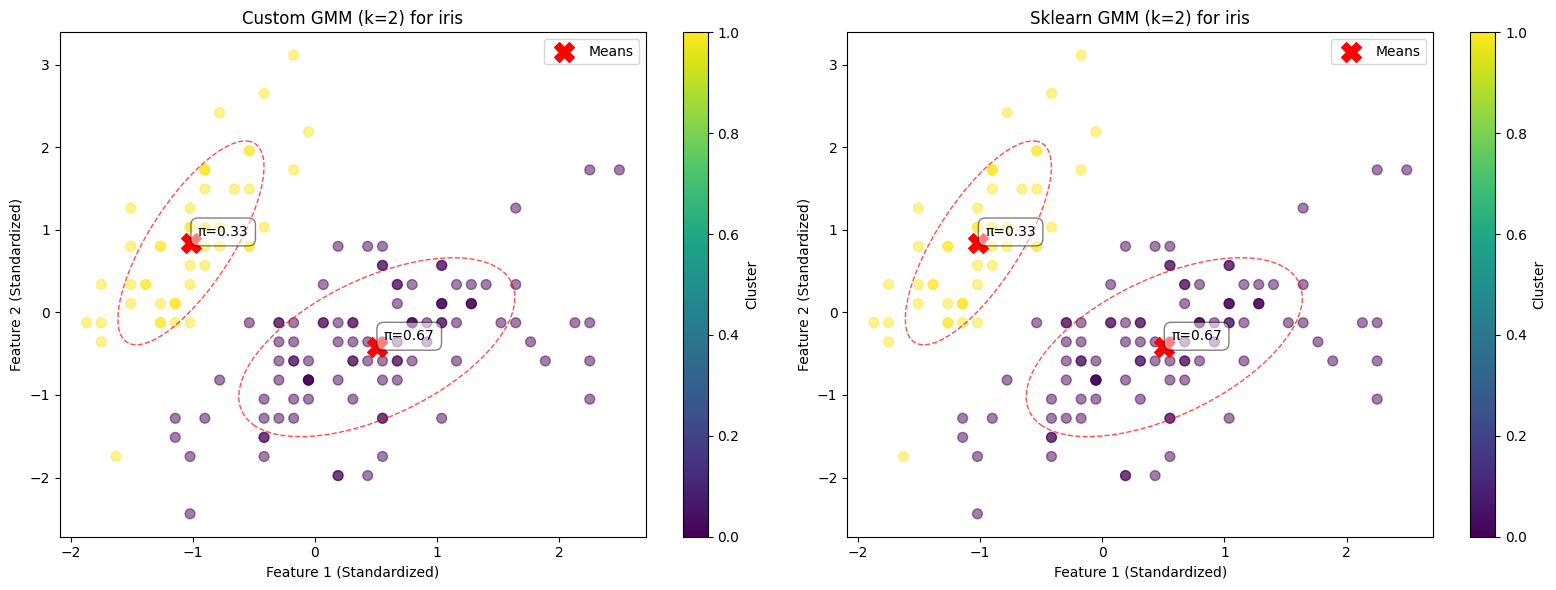


Processing ai_global_index dataset

Best K for ai_global_index: 3

Custom GMM Metrics:
Silhouette Score: 0.3906, Davies-Bouldin Index: 0.9837, Calinski-Harabasz Index: 28.8184, Adjusted Rand Score: 0.0663, Adjusted MI Score: 0.2110, Mutual Info Score: 0.2493

Sklearn GMM Metrics:
Silhouette Score: 0.4605, Davies-Bouldin Index: 0.7098, Calinski-Harabasz Index: 46.2029, Adjusted Rand Score: 0.0166, Adjusted MI Score: 0.1119, Mutual Info Score: 0.1745


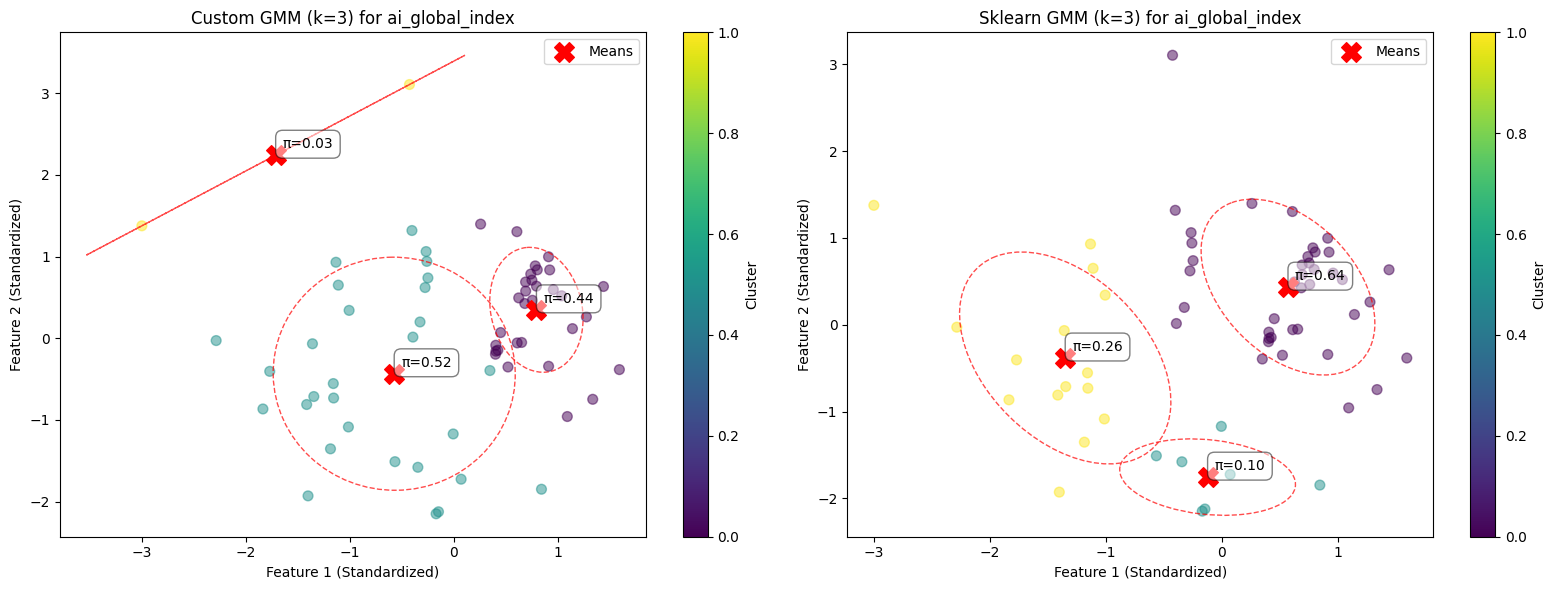


Processing global_earthquake dataset

Best K for global_earthquake: 3

Custom GMM Metrics:
Silhouette Score: 0.1051, Davies-Bouldin Index: 2.2264, Calinski-Harabasz Index: 7.9612, Adjusted Rand Score: -1.0000, Adjusted MI Score: -1.0000, Mutual Info Score: -1.0000

Sklearn GMM Metrics:
Silhouette Score: 0.1569, Davies-Bouldin Index: 1.8955, Calinski-Harabasz Index: 9.5453, Adjusted Rand Score: -1.0000, Adjusted MI Score: -1.0000, Mutual Info Score: -1.0000


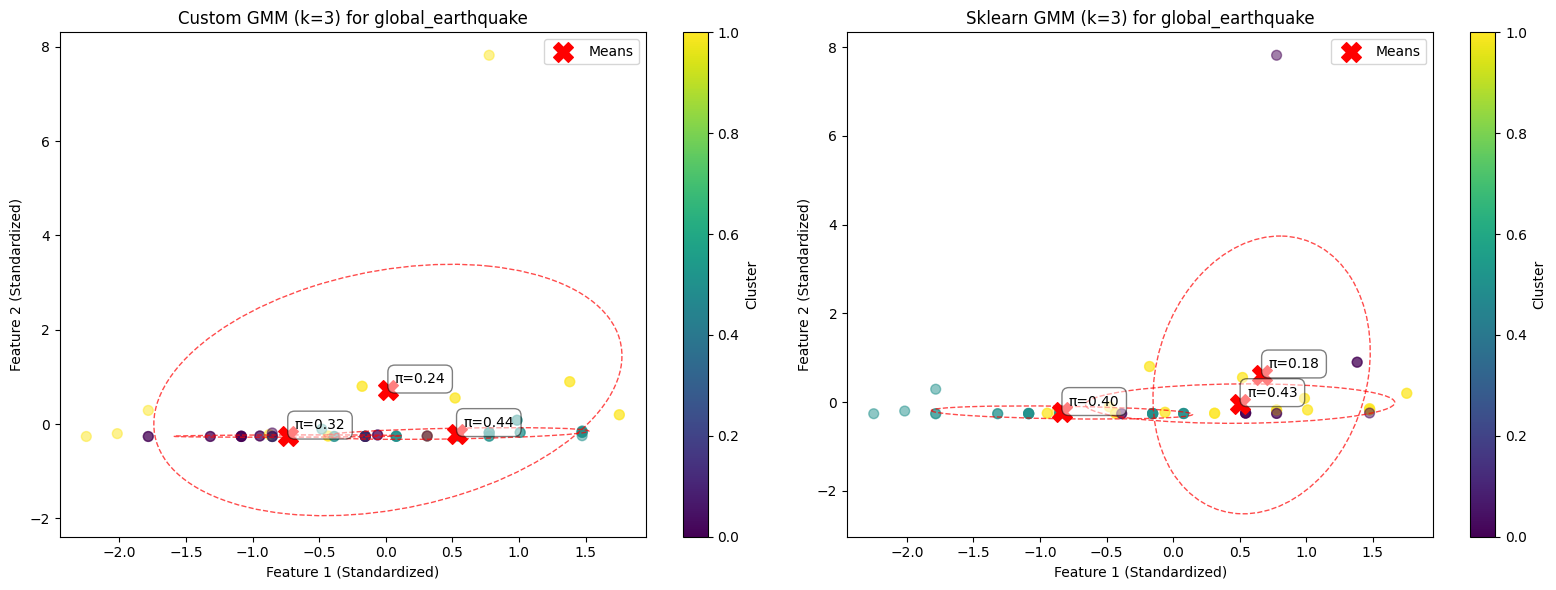

In [12]:
from sklearn.mixture import GaussianMixture

results = {}
k_range = range(2,7)  # Try different values of k from 3 to 5

for name, (original_df, true_labels) in datasets.items():
    print(f"\nProcessing {name} dataset")
    df = original_df.dropna()
    
    if name == "ai_global_index":
        numeric_cols = [
            "Talent", "Infrastructure", "Operating Environment", 
            "Research", "Development", "Government Strategy", 
            "Commercial", "Total score"
        ]
        categorical_cols = ["Income group", "Political regime", "Region"]

        # Compute dissimilarity matrix
        dissim = MixedDataDissimilarity(numeric_cols, categorical_cols)
        dist_matrix = dissim.fit_transform(df)

        # Convert dissimilarity matrix to embedding for clustering
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X = mds.fit_transform(dist_matrix)
    else:
        # For datasets that are purely numerical
        X = df.select_dtypes(include=[np.number]).values

    # Normalize data (important for GMM)
    X = StandardScaler().fit_transform(X)

    best_k = None
    best_silhouette = -1  # Start with the worst possible silhouette
    k_results = {}

    for k in k_range:
        # Custom GMM
        custom_gmm = CustomGMM(num_components=k, max_iterations=100, tolerance=1e-4,random_state=42)
        custom_gmm.fit(X)
        custom_labels = custom_gmm.predict(X)
        
        # Sklearn GMM
        sklearn_gmm = GaussianMixture(n_components=k, max_iter=100, tol=1e-4, random_state=42)
        sklearn_labels = sklearn_gmm.fit_predict(X)
        
        # Evaluate both
        custom_metrics = evaluate_clustering(X, custom_labels, true_labels=true_labels)
        sklearn_metrics = evaluate_clustering(X, sklearn_labels, true_labels=true_labels)

        # Save results
        k_results[k] = {
            "custom": {
                "silhouette": custom_metrics['silhouette_score'],
                "davies_bouldin": custom_metrics['davies_bouldin_score'],
                "calinski_harabasz": custom_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": custom_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": custom_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": custom_metrics['mutual_info_score'],
                "labels": custom_labels,
                "means": custom_gmm.means,
                "covariances": custom_gmm.covariances,
                "weights": custom_gmm.weights
            },
            "sklearn": {
                "silhouette": sklearn_metrics['silhouette_score'],
                "davies_bouldin": sklearn_metrics['davies_bouldin_score'],
                "calinski_harabasz": sklearn_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": sklearn_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": sklearn_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": sklearn_metrics['mutual_info_score'],
                "labels": sklearn_labels,
                "means": sklearn_gmm.means_,
                "covariances": sklearn_gmm.covariances_,
                "weights": sklearn_gmm.weights_
            }
        }

        # Track best silhouette (using custom GMM for selection)
        if custom_metrics['silhouette_score'] > best_silhouette:
            best_silhouette = custom_metrics['silhouette_score']
            best_k = k

    # Store final result for the dataset
    results[name] = {
        "best_k": best_k,
        "best_metrics": k_results[best_k]
    }

    # Print best result
    print(f"\nBest K for {name}: {best_k}")
    
    print("\nCustom GMM Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['custom']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['custom']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['custom']['calinski_harabasz']:.4f}, "
          f"Adjusted Rand Score: {k_results[best_k]['custom']['adjusted_rand_score']:.4f}, "
          f"Adjusted MI Score: {k_results[best_k]['custom']['adjusted_mutual_info_score']:.4f}, "
          f"Mutual Info Score: {k_results[best_k]['custom']['mutual_info_score']:.4f}")
    
    print("\nSklearn GMM Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['sklearn']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['sklearn']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['sklearn']['calinski_harabasz']:.4f}, "
          f"Adjusted Rand Score: {k_results[best_k]['sklearn']['adjusted_rand_score']:.4f}, "
          f"Adjusted MI Score: {k_results[best_k]['sklearn']['adjusted_mutual_info_score']:.4f}, "
          f"Mutual Info Score: {k_results[best_k]['sklearn']['mutual_info_score']:.4f}")

    # Plotting for best_k
    plt.figure(figsize=(16, 6))
    
    # Custom GMM plot
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['custom']['labels'], cmap="viridis", s=50, alpha=0.5)
    
    # Plot means (first two dimensions)
    means_2d = k_results[best_k]['custom']['means'][:, :2]
    plt.scatter(means_2d[:, 0], means_2d[:, 1], c='red', marker='X', s=200, label='Means')
    
    # Plot covariance ellipses
    for k in range(best_k):
        cov = k_results[best_k]['custom']['covariances'][k][:2, :2]
        mean = means_2d[k]
        
        v, w = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
        v = 2 * np.sqrt(2) * np.sqrt(v)
        
        ell = plt.matplotlib.patches.Ellipse(
            mean, v[0], v[1], angle=angle,
            fc='none', ec='red', linestyle='--', alpha=0.7)
        plt.gca().add_patch(ell)
        
        plt.annotate(f"π={k_results[best_k]['custom']['weights'][k]:.2f}",
                    xy=mean, xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

    plt.title(f"Custom GMM (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    # Sklearn GMM plot
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['sklearn']['labels'], cmap="viridis", s=50, alpha=0.5)
    
    # Plot means (first two dimensions)
    sklearn_means_2d = k_results[best_k]['sklearn']['means'][:, :2]
    plt.scatter(sklearn_means_2d[:, 0], sklearn_means_2d[:, 1], c='red', marker='X', s=200, label='Means')
    
    # Plot covariance ellipses
    for k in range(best_k):
        cov = k_results[best_k]['sklearn']['covariances'][k][:2, :2]
        mean = sklearn_means_2d[k]
        
        v, w = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
        v = 2 * np.sqrt(2) * np.sqrt(v)
        
        ell = plt.matplotlib.patches.Ellipse(
            mean, v[0], v[1], angle=angle,
            fc='none', ec='red', linestyle='--', alpha=0.7)
        plt.gca().add_patch(ell)
        
        plt.annotate(f"π={k_results[best_k]['sklearn']['weights'][k]:.2f}",
                    xy=mean, xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

    plt.title(f"Sklearn GMM (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    plt.tight_layout()
    plt.show()

In [13]:
summary = {
    'metric': [],
    'iris': [],
    'ai_global_index': [],
    'global_earthquake': []
}

# Helper function to extract specific metric from results
def get_metric(dataset_name, impl, metric_name):
    return results[dataset_name]["best_metrics"][impl][metric_name]

# List of datasets and metrics to collect
dataset_names = ['iris', 'ai_global_index', 'global_earthquake']
implementations = ['custom', 'sklearn']
metrics = [
    'silhouette',
    'davies_bouldin',
    'calinski_harabasz',
    'adjusted_rand_score',
    'adjusted_mutual_info_score',
    'mutual_info_score'
]

# Collect all metrics
for impl in implementations:
    for metric in metrics:
        row_name = f"{impl}_{metric}"
        summary['metric'].append(row_name)
        for dataset in dataset_names:
            value = get_metric(dataset, impl, metric)
            summary[dataset].append(value)

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Optional: Reorder columns
summary_df = summary_df[['metric'] + dataset_names]

# Save to CSV
summary_df.to_csv("./../results/gmm_results.csv", index=False)
# Save results to CSV
# results_df = pd.DataFrame(results)
# results_df.to_csv("./../results/gmm_results.csv")